#Quantum Support Vector Machines
###Hecho por Enrique Ramos García

##Objetivo
El objetivo de esta práctica es implementar un modelo cuántico de máquinas de vectores soporte haciendo uso de las librerías _qiskit_ y _sklearn_. Compararemos dicho modelo con uno clásico para ver su rendimiento así como las diferencias en las clasificaciones de los datos (matriz de confusión).


##Desarrollo
Para el desarrollo de esta práctica primero instalamos qiskit  y qiskit_machine_learning y, posteriormente, importamos todas las librerías necesarias para el proceso.

In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_machine_learning

In [ ]:
from sklearn import datasets, svm, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import seaborn as sbn

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import os

Tras esto, importamos el dataset que utilizaremos en un dataframe de pandas. En este caso, el dataset trata sobre el consumo de sustancias ilegales e índices de diferentes estados de ánimo (felicidad, tranquilidad, etc.)
Tras importar el dataset realizamos el preprocesamiento. En este caso eliminamos los atributos que no nos interesan, cambiamos el target de string a numérico (a partir de consumo por semana se considera consumidor a la persona) y dividir el dataset en data y target.

In [ ]:
dataset = pd.read_csv('drug_consumption.csv',encoding='latin1',sep=',', header=None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [ ]:
datanew = dataset.drop(dataset.columns[[0,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31]], axis=1)
datanew[18] = datanew[18].map({'CL0': 0, 'CL1': 0, 'CL2': 0, 'CL3': 0, 'CL4': 1, 'CL5': 1, 'CL6':  1})

target = datanew[18]
data = datanew.iloc[:,0:12]
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


Tras el preprocesamiento, realizamos una matriz de correlación del dataset para ver como se relacionan los atributos entre sí.

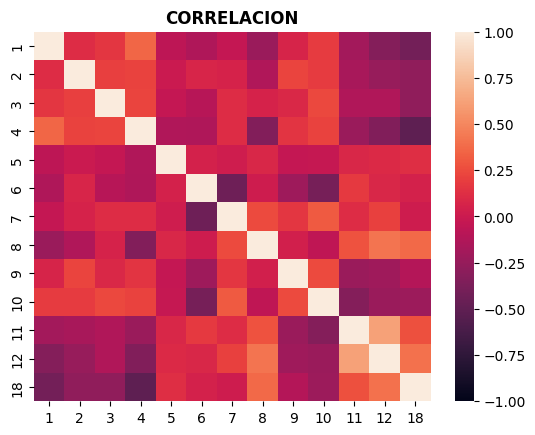

In [ ]:
matriz_correlacion = datanew.corr()
df_corr = pd.DataFrame(matriz_correlacion)
fig, ax = plt.subplots()
sbn.heatmap(df_corr, vmin=-1, vmax=1, annot=False);
ax.set_title('CORRELACION', weight='bold')
plt.show()

Debido a que entrenar un QSVM con un dataset con tantos atributos supondría mucho tiempo ordenaremos los atributos de mayor a menor correlación y mediante el método del codo escogeremos los más significativos

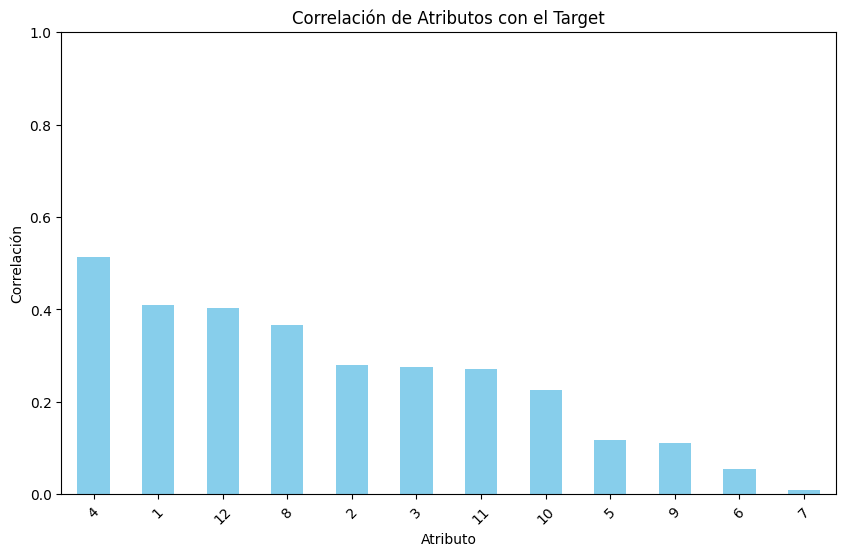

In [ ]:
correlation_matrix = data.corrwith(target)

# Ordena la matriz de correlación en orden descendente
correlation_matrix = correlation_matrix.abs().sort_values(ascending=False)

# Crea un gráfico de barras ordenado de mayor a menor
plt.figure(figsize=(10, 6))
correlation_matrix.plot(kind='bar', color='skyblue')
plt.title('Correlación de Atributos con el Target')
plt.xlabel('Atributo')
plt.ylabel('Correlación')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

No se observa un "*codo*" pero por motivos de desarrollo de la práctica nos quedaremos con las primeras tres variables.

In [ ]:
data = datanew.iloc[:,[0,3,11]]
data.head()

,1,4,12
0,0.49788,0.96082,-1.18084
1,-0.07854,0.96082,-0.21575
2,0.49788,0.96082,0.40148
3,-0.95197,0.96082,-1.18084
4,0.49788,0.96082,-0.21575


Ahora procedemos a dividir los datos en test (30%) y train (70%) con la función implementada en la librería de sklearn. Los datos se barajearan aleatoriamente con una semilla para reproducir los mismos resultados en ejecuciones posteriores.

In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(data, target, test_size=0.3, shuffle=True, random_state=123456)
print(len(train_features),len(test_features))
print(len(train_labels),len(test_labels))

1319 566
1319 566


###SVM CLÁSICO
Primero normalizamos los datos numéricos

In [ ]:
scalern = MinMaxScaler()
train_featuresn = scalern.fit_transform(train_features)
test_featuresn = scalern.fit_transform(test_features)
test_labelsn = test_labels
train_labelsn = train_labels

Ahora definimos el clasificador SVM clásico con la función SVC de sklearn. El kernel será radial basis function y el parámetro gamma = 0.001. Lo ajustamos con el método .fit(), tanto con los valores normalizados como con los normales, y vemos la precisión con los datos de test.

In [ ]:
svm1 = SVC(gamma=0.001, kernel = 'rbf')
svm2 = SVC(gamma=0.001, kernel = 'rbf')
svm1.fit(train_features, train_labelsn)
svm2.fit(train_featuresn, train_labelsn)

score_callable_function = svm1.score(test_features, test_labelsn)
print(f"Test score not normalized data: {score_callable_function}")
score_callable_function = svm2.score(test_featuresn, test_labelsn)
print(f"Test score normalized data: {score_callable_function}")

Test score not normalized data: 0.7703180212014135
Test score normalized data: 0.5759717314487632


Podemos observar que obtenemos un 80% de precisión aproximadamente con el modelo entrenado por los datos sin normalizar mientras que un 60% con los datos normalizados.

###SVM Cuántico
Procedemos a realizar el modelo pero con un kernel cuántico. Para ello primero reduciremos el tamaño del dataset (para que sea viable) a 500 registros. De estos 400 son de train (80%) y 100 de test (20%).

In [ ]:
train_features = train_features.iloc[0:400,:]
test_features = test_features.iloc[0:100,:]
test_featuresx = test_features
train_labels = train_labels.iloc[0:400]
test_labels = test_labels.iloc[0:100]

Debido a que los datos serán mapeados a un qubit en fase. Para que cada uno sea único y no haya posibilidad de valores repetidos haremos una normalización de los datos entre 0 y 2pi. Esto se debe a que cada dato se encontrará en el plano XY de la esfera de bloch y tiene una amplitud de 2pi.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)

Ahora, definimos nuestro circuito de mapeado de los datos a qubits. En este caso haremos uso de uno predefinido llamado ZZFeatureMap. Dentro de esta función definimos feature_dimension (número de atributos de los datos), reps (número de veces que se repite el circuito en el mapeo) y entanglement (tipo de entrelazamiento). El ZZFeatureMap tiene la siguiente forma:
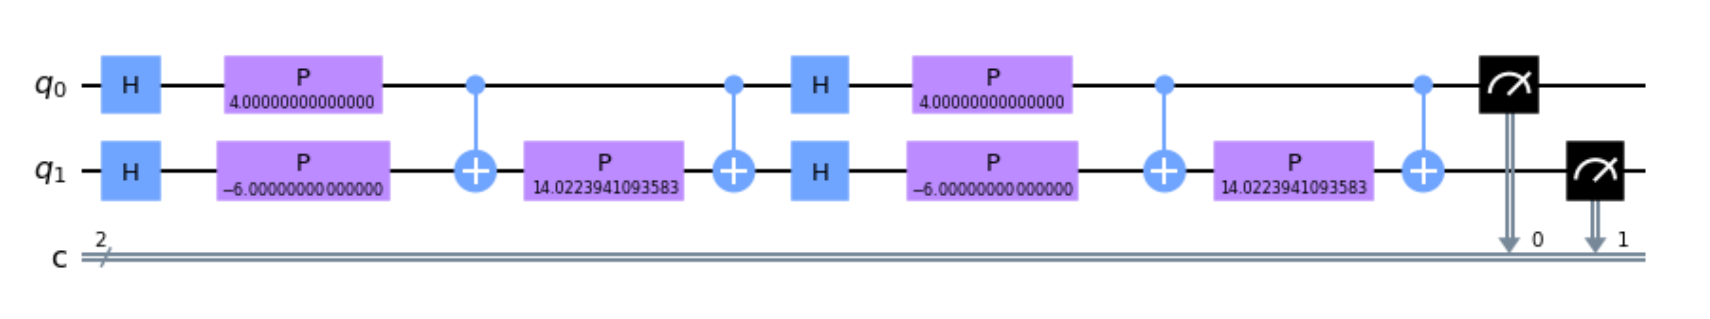

Por otra parte, el Sampler nos sirve para calcular la distribución de cuasi-probabillidades de los bits de circuitos cuánticos. Explicado de forma más sencilla, hace de simulador cuántico.
La función ComputeUncompute() sirve para calcular la fidelidad de estado de dos circuitos cuánticos utilizando el método ComputeUncompute. Esto lo utilizaremos para el cálculo de la matriz de Gram, la cual será nuestro kernel. Con el fidelity básicamente lo que estamos es definiendo la operación que se hace entre los vectores. En este caso, y como vimos en clase, es la siguiente:
  
  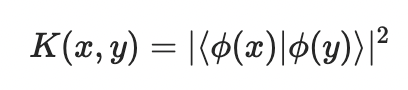

Por último, lo que hacemos es calcular nuestro kernel con el mapeo cuántico de los vectores y posteriormente el producto interno de todos los vectores por pares. Para obtener la matriz del kernel se utiliza el método .evaluate de esta clase.

In [ ]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)
kernelmat = adhoc_kernel.evaluate(train_features)
np.save('kernelmat.npy', kernelmat)

In [ ]:
kernelmattest = adhoc_kernel.evaluate(train_features, test_features)
np.save('kernelmattest.npy', kernelmattest)

In [ ]:
#Cargamos matrices de Gram calculadas ya
kernelmat = np.load('kernelmat.npy')
kernelmattest = np.load('kernelmattest.npy')

Tras construir la matriz del producto interno, definimos un clasificador con un kernel precomputado. Este clasificador lo entrenamos dándole el kernel y los labels.

In [ ]:
qsvc = SVC(kernel='precomputed')
qsvc.fit(kernelmat, train_labels)

SVC(kernel='precomputed')

Posteriormente comprobamos la precisión con los datos de test. Para ello realizamos la matriz de Gram del producto interno de los datos de train por los de test por pares. Hacemos uso del método .score para pasarle dicha matriz y los labels recibiendo así el accurracy con los datos de test.

In [ ]:
#Matriz calculada y guardada en celdas 22 y 23 con el fin de evitar realizar el cálculo al ejecutar el código
score = qsvc.score(np.transpose(kernelmattest), test_labels)
print(f"Test score: {score}")

Test score: 0.51


Podemos observar que el resultado del QSVM es bastante deficiente ya que podríamos obtener el mismo resultado haciendo aleatoriamente la elección. Este mal resultado se puede deber a la falta de registros o a la eliminación de atributos y por consiguiente información.

##Matrices de Confusión
Primero veamos la matriz de confusión del SVM sin normalizar. Se puede observar que lo que mejor clasifica es aquellos que no consumen cannabis. Es decir, este modelo es bueno para saber si alguien no consume debido a sus pocos falsos positivos. No obstante, no es bueno para predecir gente que consume pues es muy poco preciso.

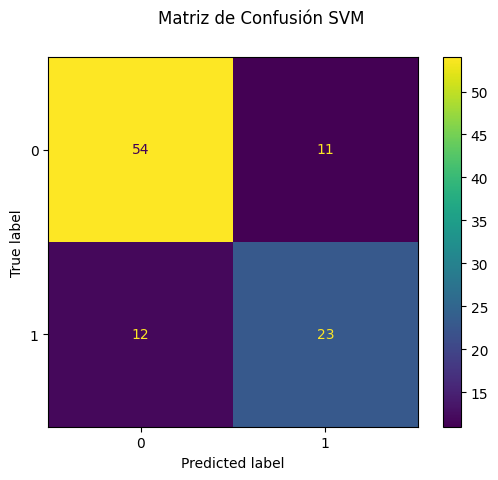

In [ ]:
y_pred = svm1.predict(test_featuresx)

disp = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
disp.figure_.suptitle("Matriz de Confusión SVM")
plt.show()

Por otra parte, el QSVM, como es de esperar, es malo para todo puesto que tiene muy baja precisión. Podríamos decir que el modelo QSVM es tirar una moneda y ver el resultado.

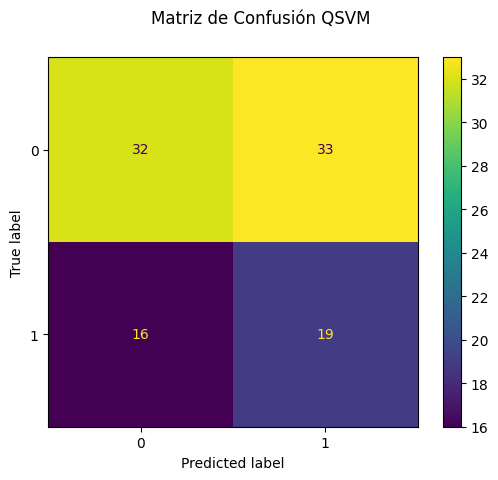

In [ ]:
y_predq = qsvc.predict(np.transpose(kernelmattest))

disp = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, y_predq)
disp.figure_.suptitle("Matriz de Confusión QSVM")
plt.show()

Por otra parte, cabe mencionar la matriz de confusión enfrentada de ambos modelos. Podemos observar que casi todos aquellos registros que el SVM clásico clasifica como 1 también son clasificados como 1 por el QSVM. A parte de eso, no hay nada más interesante puesto que, como se ha comprobado, la precisión del QSVM es muy baja.

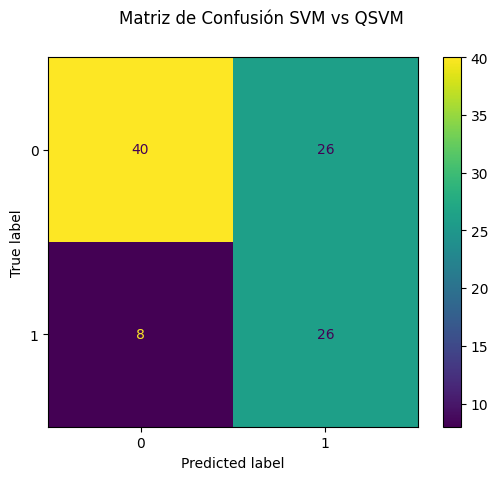

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_pred, y_predq)
disp.figure_.suptitle("Matriz de Confusión SVM vs QSVM")
plt.show()

##Extra
Cabe mencionar que hay una librería dentro de Qiskit que nos permite agilizar todo el proceso de generación de kernel cuántico. Esta funciona como la librería svm de sklearn. A continuación un ejemplo de su uso:

In [ ]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.51


Se observa que la precisión es la misma que la que se obtuvo antes con el modelo QSVM con kernel precomputado